# Prot T5 Finetuning
# per residue classification

This notebook allows you to finetune ProtT5 to your own datasets

The protein language model ProtT5 was first published [here](https://ieeexplore.ieee.org/document/9477085) and is available on [github](https://github.com/agemagician/ProtTrans). We use the [huggingface](https://huggingface.co/Rostlab/prot_t5_xl_uniref50) checkpoint.

For better perfomance we apply [Parameter-Efficient Fine-Tuning (PEFT)](https://huggingface.co/blog/peft). For this we apply [LoRA: Low-Rank Adaptation of Large Language Models](https://arxiv.org/abs/2106.09685).

For higher memory efficiency we also utilize the [deepspeed](https://github.com/microsoft/DeepSpeed) implementation of [huggingface](https://huggingface.co/docs/accelerate/usage_guides/deepspeed).

The core training loop is implemented with the pytorch [huggingface trainer](https://huggingface.co/docs/transformers/main_classes/trainer) 

## Imports and env. variables

In [1]:
#import dependencies
import os.path
os.chdir("set a path here")


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from torch.utils.data import DataLoader

import re
import numpy as np
import pandas as pd
import copy

import transformers, datasets
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.t5.modeling_t5 import T5Config, T5PreTrainedModel, T5Stack
from transformers.utils.model_parallel_utils import assert_device_map, get_device_map
from transformers import T5EncoderModel, T5Tokenizer
from transformers import TrainingArguments, Trainer, set_seed
from transformers import DataCollatorForTokenClassification

from evaluate import load
from datasets import Dataset

from tqdm import tqdm
import random

from scipy import stats
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

In [2]:
# Set environment variables to run Deepspeed from a notebook
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "9993"  # modify if RuntimeError: Address already in use
os.environ["RANK"] = "0"
os.environ["LOCAL_RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"

# Environment to run this notebook


These are the versions of the core packages we use to run this notebook:

In [3]:
print("Torch version: ",torch.__version__)
print("Cuda version: ",torch.version.cuda)
print("Numpy version: ",np.__version__)
print("Pandas version: ",pd.__version__)
print("Transformers version: ",transformers.__version__)
print("Datasets version: ",datasets.__version__)

Torch version:  1.13.1
Cuda version:  11.7
Numpy version:  1.22.3
Pandas version:  1.5.3
Transformers version:  4.26.1
Datasets version:  2.9.0


**For easy setup of this environment you can use the finetuning.yml File provided in this folder**

check here for [setting up env from a yml File](https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file)

# Input data

Provide your training and validation data in seperate pandas dataframes 

example shown below

**Modify the data loading part above as needed for your data**

To run the training you need two dataframes (training and validation) each with the columns "sequence" and "label" and "mask"

Columns are:
+ protein sequence
+ label is a list of len(protein sequence) with integers (from 0 to number of classes - 1) corresponding to predicted class at this position
+ mask gives the possibility to ignore parts of the positions. Provide a list of len(protein sequence) where 1 is processed, while 0 is ignored

In [4]:
# For this example we import the secondary_structure dataset from https://github.com/J-SNACKKB/FLIP
# For details, see publication here: https://openreview.net/forum?id=p2dMLEwL8tF
import requests
import zipfile
from io import BytesIO
from Bio import SeqIO
import tempfile

# Download the zip file from GitHub
url = 'https://github.com/J-SNACKKB/FLIP/raw/main/splits/secondary_structure/splits.zip'

response = requests.get(url)
zip_file = zipfile.ZipFile(BytesIO(response.content))

# Extract the fasta file to a temporary directory
# Sequence File
with tempfile.TemporaryDirectory() as temp_dir:
    zip_file.extract('splits/sequences.fasta', temp_dir)

    # Load the fasta files
    fasta_file = open(temp_dir + '/splits/sequences.fasta')
    
    # Load FASTA file using Biopython
    sequences = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        sequences.append([record.name, str(record.seq)])

    # Create dataframe
    df = pd.DataFrame(sequences, columns=["name", "sequence"])

# Mask File
with tempfile.TemporaryDirectory() as temp_dir:
    zip_file.extract('splits/mask.fasta', temp_dir)

    # Load the fasta files
    fasta_file = open(temp_dir + '/splits/mask.fasta')
    
    # Load FASTA file using Biopython
    sequences = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        sequences.append([str(record.seq)])

    # Add to dataframe
    df = pd.concat([df, pd.DataFrame(sequences, columns=["mask"])], axis=1) 
    
# Label File
with tempfile.TemporaryDirectory() as temp_dir:
    zip_file.extract('splits/sampled.fasta', temp_dir)

    # Load the fasta files
    fasta_file = open(temp_dir + '/splits/sampled.fasta')
    
    # Load FASTA file using Biopython
    sequences = []
    for record in SeqIO.parse(fasta_file, "fasta"):

        sequences.append([str(record.seq), record.description])

    # Add to dataframe
    df = pd.concat([df, pd.DataFrame(sequences, columns=[ "label", "dataset"])], axis=1)  

# Get data split information
df["validation"]=df.dataset.str.split("=").str[2]
# str to bool
df['validation'] = df['validation'].apply(lambda x: x == 'True')

# Extract data split information
df["dataset"]=df.dataset.str.split("=").str[1]
df["dataset"]=df.dataset.str.split(" ").str[0]

# Preprocess mask and label to lists
# C is class 0, E is class 1, H is class 2
df['label'] = df['label'].str.replace("C","0")
df['label'] = df['label'].str.replace("E","1")
df['label'] = df['label'].str.replace("H","2")

# str to integer
df['label'] = df['label'].apply(lambda x: [int(i) for i in x])
df['mask'] = df['mask'].apply(lambda x: [int(i) for i in x])


df.head(5)

,name,sequence,mask,label,dataset,validation
0,1es5-A,VTKPTIAAVGGYAMNNGTGTTLYTKAADTRRSTGSTTKIMTAKVVL...,"[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...",train,False
1,2a6h-E,MAEPGIDKLFGMVDSKYRLTVVVAKRAQQLLRHGFKNTVLEPEERP...,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, ...",train,False
2,5b1a-P,MTHQTHAYHMVNPSPWPLTGALSALLMTSGLTMWFHFNSMTLLMIG...,"[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",train,False
3,5ehi-C,GTGSQGETLGEKWKKKLNQLSRKEFDLYKKSGITEVDRTEAKEGLK...,"[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, ...",train,False
4,5egf-A,HHHHHHAVAKDSTESKSWEPFSLSPIKDPQALHAALCSKNVIPVTS...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",train,False


In [5]:
# Seperate test and train data 
my_test=df[df.dataset=="test"].reset_index(drop=True)
df=df[df.dataset=="train"]

# Get train and validation data
my_train=df[df.validation!=True].reset_index(drop=True)
my_valid=df[df.validation==True].reset_index(drop=True)

# Drop unneeded columns
my_train= my_train[["sequence","label","mask"]]
my_valid= my_valid[["sequence","label","mask"]]
my_test =  my_test[["sequence","label","mask"]]

# Set labels where mask == 0 to -100 (will be ignored by pytorch loss)
my_train['label'] = my_train.apply(lambda row: [-100 if m == 0 else l for l, m in zip(row['label'], row['mask'])], axis=1)
my_valid['label'] = my_valid.apply(lambda row: [-100 if m == 0 else l for l, m in zip(row['label'], row['mask'])], axis=1)
my_test['label'] = my_test.apply(lambda row: [-100 if m == 0 else l for l, m in zip(row['label'], row['mask'])], axis=1)

In [6]:
my_train.head(5)

,sequence,label,mask
0,VTKPTIAAVGGYAMNNGTGTTLYTKAADTRRSTGSTTKIMTAKVVL...,"[-100, -100, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,MAEPGIDKLFGMVDSKYRLTVVVAKRAQQLLRHGFKNTVLEPEERP...,"[-100, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,MTHQTHAYHMVNPSPWPLTGALSALLMTSGLTMWFHFNSMTLLMIG...,"[-100, -100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,GTGSQGETLGEKWKKKLNQLSRKEFDLYKKSGITEVDRTEAKEGLK...,"[-100, -100, -100, -100, -100, -100, 0, 0, 2, ...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,HHHHHHAVAKDSTESKSWEPFSLSPIKDPQALHAALCSKNVIPVTS...,"[-100, -100, -100, -100, -100, -100, -100, -10...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [7]:
my_valid.head(5)

,sequence,label,mask
0,GMKVTNYQGATIDPYSKGLGMVPGTSIQLTDAARLEWNLLNEDVSL...,"[-100, -100, -100, -100, -100, -100, -100, -10...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ..."
1,AMPLDAGGQNSTQMVLAPGASIFRCRQCGQTISRRDWLLPMGGDHE...,"[-100, -100, -100, -100, -100, -100, -100, -10...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,MHFEAYPPEVNSANIYAGPGPDSMLAAARAWRSLDVEMTAVQRSFN...,"[-100, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,MNIPTTTTKGEQAKSQLIAAALAQFGEYGLHATTRDIAALAGQNIA...,"[-100, -100, -100, -100, -100, -100, 0, 2, 2, ...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,GTSYENSLLVKQSGSLPLSSLTHVLRSLTPNARGIFRLLIKYQLDN...,"[-100, -100, -100, -100, -100, -100, -100, -10...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


# PT5 Model and Low Rank Adaptation

## LoRA modification definition

Implementation taken from https://github.com/r-three/t-few

(https://github.com/r-three/t-few/blob/master/src/models/lora.py, https://github.com/r-three/t-few/tree/master/configs)

In [8]:
# Modifies an existing transformer and introduce the LoRA layers

class LoRAConfig:
    def __init__(self):
        self.lora_rank = 4
        self.lora_init_scale = 0.01
        self.lora_modules = ".*SelfAttention|.*EncDecAttention"
        self.lora_layers = "q|k|v|o"
        self.trainable_param_names = ".*layer_norm.*|.*lora_[ab].*"
        self.lora_scaling_rank = 1
        # lora_modules and lora_layers are speicified with regular expressions
        # see https://www.w3schools.com/python/python_regex.asp for reference
        
class LoRALinear(nn.Module):
    def __init__(self, linear_layer, rank, scaling_rank, init_scale):
        super().__init__()
        self.in_features = linear_layer.in_features
        self.out_features = linear_layer.out_features
        self.rank = rank
        self.scaling_rank = scaling_rank
        self.weight = linear_layer.weight
        self.bias = linear_layer.bias
        if self.rank > 0:
            self.lora_a = nn.Parameter(torch.randn(rank, linear_layer.in_features) * init_scale)
            if init_scale < 0:
                self.lora_b = nn.Parameter(torch.randn(linear_layer.out_features, rank) * init_scale)
            else:
                self.lora_b = nn.Parameter(torch.zeros(linear_layer.out_features, rank))
        if self.scaling_rank:
            self.multi_lora_a = nn.Parameter(
                torch.ones(self.scaling_rank, linear_layer.in_features)
                + torch.randn(self.scaling_rank, linear_layer.in_features) * init_scale
            )
            if init_scale < 0:
                self.multi_lora_b = nn.Parameter(
                    torch.ones(linear_layer.out_features, self.scaling_rank)
                    + torch.randn(linear_layer.out_features, self.scaling_rank) * init_scale
                )
            else:
                self.multi_lora_b = nn.Parameter(torch.ones(linear_layer.out_features, self.scaling_rank))

    def forward(self, input):
        if self.scaling_rank == 1 and self.rank == 0:
            # parsimonious implementation for ia3 and lora scaling
            if self.multi_lora_a.requires_grad:
                hidden = F.linear((input * self.multi_lora_a.flatten()), self.weight, self.bias)
            else:
                hidden = F.linear(input, self.weight, self.bias)
            if self.multi_lora_b.requires_grad:
                hidden = hidden * self.multi_lora_b.flatten()
            return hidden
        else:
            # general implementation for lora (adding and scaling)
            weight = self.weight
            if self.scaling_rank:
                weight = weight * torch.matmul(self.multi_lora_b, self.multi_lora_a) / self.scaling_rank
            if self.rank:
                weight = weight + torch.matmul(self.lora_b, self.lora_a) / self.rank
            return F.linear(input, weight, self.bias)

    def extra_repr(self):
        return "in_features={}, out_features={}, bias={}, rank={}, scaling_rank={}".format(
            self.in_features, self.out_features, self.bias is not None, self.rank, self.scaling_rank
        )


def modify_with_lora(transformer, config):
    for m_name, module in dict(transformer.named_modules()).items():
        if re.fullmatch(config.lora_modules, m_name):
            for c_name, layer in dict(module.named_children()).items():
                if re.fullmatch(config.lora_layers, c_name):
                    assert isinstance(
                        layer, nn.Linear
                    ), f"LoRA can only be applied to torch.nn.Linear, but {layer} is {type(layer)}."
                    setattr(
                        module,
                        c_name,
                        LoRALinear(layer, config.lora_rank, config.lora_scaling_rank, config.lora_init_scale),
                    )
    return transformer

## Classification model definition 

adding a token classification head on top of the encoder model

modified from [EsmForTokenClassification](https://github.com/huggingface/transformers/blob/v4.30.0/src/transformers/models/esm/modeling_esm.py#L1178)

In [9]:
class ClassConfig:
    def __init__(self, dropout=0.2, num_labels=3):
        self.dropout_rate = dropout
        self.num_labels = num_labels

class T5EncoderForTokenClassification(T5PreTrainedModel):

    def __init__(self, config: T5Config, class_config):
        super().__init__(config)
        self.num_labels = class_config.num_labels
        self.config = config

        self.shared = nn.Embedding(config.vocab_size, config.d_model)

        encoder_config = copy.deepcopy(config)
        encoder_config.use_cache = False
        encoder_config.is_encoder_decoder = False
        self.encoder = T5Stack(encoder_config, self.shared)

        self.dropout = nn.Dropout(class_config.dropout_rate) 
        self.classifier = nn.Linear(config.hidden_size, class_config.num_labels)

        # Initialize weights and apply final processing
        self.post_init()

        # Model parallel
        self.model_parallel = False
        self.device_map = None

    def parallelize(self, device_map=None):
        self.device_map = (
            get_device_map(len(self.encoder.block), range(torch.cuda.device_count()))
            if device_map is None
            else device_map
        )
        assert_device_map(self.device_map, len(self.encoder.block))
        self.encoder.parallelize(self.device_map)
        self.classifier = self.classifier.to(self.encoder.first_device)
        self.model_parallel = True

    def deparallelize(self):
        self.encoder.deparallelize()
        self.encoder = self.encoder.to("cpu")
        self.model_parallel = False
        self.device_map = None
        torch.cuda.empty_cache()

    def get_input_embeddings(self):
        return self.shared

    def set_input_embeddings(self, new_embeddings):
        self.shared = new_embeddings
        self.encoder.set_input_embeddings(new_embeddings)

    def get_encoder(self):
        return self.encoder

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            inputs_embeds=inputs_embeds,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]
        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()

            active_loss = attention_mask.view(-1) == 1
            active_logits = logits.view(-1, self.num_labels)

            active_labels = torch.where(
              active_loss, labels.view(-1), torch.tensor(-100).type_as(labels)
            )

            valid_logits=active_logits[active_labels!=-100]
            valid_labels=active_labels[active_labels!=-100]
            
            valid_labels=valid_labels.type(torch.LongTensor).to('cuda:0')
            
            loss = loss_fct(valid_logits, valid_labels)
            
        
        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

## Modified ProtT5 model
this creates a ProtT5 model with prediction head and LoRA modification

In [10]:
def PT5_classification_model(num_labels):
    # Load PT5 and tokenizer
    model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")
    tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50") 
    
    # Create new Classifier model with PT5 dimensions
    class_config=ClassConfig(num_labels=num_labels)
    class_model=T5EncoderForTokenClassification(model.config,class_config)
    
    # Set encoder and embedding weights to checkpoint weights
    class_model.shared=model.shared
    class_model.encoder=model.encoder    
    
    # Delete the checkpoint model
    model=class_model
    del class_model
    
    # Print number of trainable parameters
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("ProtT5_Classfier\nTrainable Parameter: "+ str(params))    
 
    # Add model modification lora
    config = LoRAConfig()
    
    # Add LoRA layers
    model = modify_with_lora(model, config)
    
    # Freeze Embeddings and Encoder (except LoRA)
    for (param_name, param) in model.shared.named_parameters():
                param.requires_grad = False
    for (param_name, param) in model.encoder.named_parameters():
                param.requires_grad = False       

    for (param_name, param) in model.named_parameters():
            if re.fullmatch(config.trainable_param_names, param_name):
                param.requires_grad = True

    # Print trainable Parameter          
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("ProtT5_LoRA_Classfier\nTrainable Parameter: "+ str(params) + "\n")
    
    return model, tokenizer

# Training Definition 

## Deepspeed config

In [11]:
# Deepspeed config for optimizer CPU offload

ds_config = {
    "fp16": {
        "enabled": "auto",
        "loss_scale": 0,
        "loss_scale_window": 1000,
        "initial_scale_power": 16,
        "hysteresis": 2,
        "min_loss_scale": 1
    },

    "optimizer": {
        "type": "AdamW",
        "params": {
            "lr": "auto",
            "betas": "auto",
            "eps": "auto",
            "weight_decay": "auto"
        }
    },

    "scheduler": {
        "type": "WarmupLR",
        "params": {
            "warmup_min_lr": "auto",
            "warmup_max_lr": "auto",
            "warmup_num_steps": "auto"
        }
    },

    "zero_optimization": {
        "stage": 2,
        "offload_optimizer": {
            "device": "cpu",
            "pin_memory": True
        },
        "allgather_partitions": True,
        "allgather_bucket_size": 2e8,
        "overlap_comm": True,
        "reduce_scatter": True,
        "reduce_bucket_size": 2e8,
        "contiguous_gradients": True
    },

    "gradient_accumulation_steps": "auto",
    "gradient_clipping": "auto",
    "steps_per_print": 2000,
    "train_batch_size": "auto",
    "train_micro_batch_size_per_gpu": "auto",
    "wall_clock_breakdown": False
}

## Training functions

In [12]:
# Set random seeds for reproducibility of your trainings run
def set_seeds(s):
    torch.manual_seed(s)
    np.random.seed(s)
    random.seed(s)
    set_seed(s)

# Dataset creation
def create_dataset(tokenizer,seqs,labels):
    tokenized = tokenizer(seqs, max_length=1024, padding=True, truncation=True)
    dataset = Dataset.from_dict(tokenized)
    # we need to cut of labels after 1023 positions for the data collator to add the correct padding (1023 + 1 special tokens)
    labels = [l[:1023] for l in labels] 
    dataset = dataset.add_column("labels", labels)
     
    return dataset
    
# Main training fuction
def train_per_residue(
        train_df,         #training data
        valid_df,         #validation data      
        num_labels= 3,    #number of classes
    
        # effective training batch size is batch * accum
        # we recommend an effective batch size of 8 
        batch= 4,         #for training
        accum= 2,         #gradient accumulation
    
        val_batch = 16,   #batch size for evaluation
        epochs= 10,       #training epochs
        lr= 3e-4,         #recommended learning rate
        seed= 42,         #random seed
        deepspeed= True,  #if gpu is large enough disable deepspeed for training speedup
        gpu= 1 ):         #gpu selection (1 for first gpu)

    # Set gpu device
    os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu-1)
    
    # Set all random seeds
    set_seeds(seed)
    
    # load model
    model, tokenizer = PT5_classification_model(num_labels=num_labels)

    # Preprocess inputs
    # Replace uncommon AAs with "X"
    train_df["sequence"]=train_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
    valid_df["sequence"]=valid_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
    # Add spaces between each amino acid for PT5 to correctly use them
    train_df['sequence']=train_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)
    valid_df['sequence']=valid_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)


    # Create Datasets
    train_set=create_dataset(tokenizer,list(train_df['sequence']),list(train_df['label']))
    valid_set=create_dataset(tokenizer,list(valid_df['sequence']),list(valid_df['label']))

    # Huggingface Trainer arguments
    args = TrainingArguments(
        "./",
        evaluation_strategy = "steps",
        eval_steps = 500,
        logging_strategy = "epoch",
        save_strategy = "no",
        learning_rate=lr,
        per_device_train_batch_size=batch,
        #per_device_eval_batch_size=val_batch,
        per_device_eval_batch_size=batch,
        gradient_accumulation_steps=accum,
        num_train_epochs=epochs,
        seed = seed,
        deepspeed= ds_config if deepspeed else None,
    ) 

    # Metric definition for validation data
    def compute_metrics(eval_pred):

        metric = load("accuracy")
        predictions, labels = eval_pred
        
        labels = labels.reshape((-1,))
        
        predictions = np.argmax(predictions, axis=2)
        predictions = predictions.reshape((-1,))
        
        predictions = predictions[labels!=-100]
        labels = labels[labels!=-100]
        
        return metric.compute(predictions=predictions, references=labels)

    # For token classification we need a data collator here to pad correctly
    data_collator = DataCollatorForTokenClassification(tokenizer) 

    # Trainer          
    trainer = Trainer(
        model,
        args,
        train_dataset=train_set,
        eval_dataset=valid_set,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )    
    
    # Train model
    trainer.train()

    return tokenizer, model, trainer.state.log_history


# Run Training

## Training

In [13]:
tokenizer, model, history = train_per_residue(my_train, my_valid, num_labels=3, batch=1, accum=1, epochs=1, seed=42, gpu=2)

Some weights of the model checkpoint at Rostlab/prot_t5_xl_uniref50 were not used when initializing T5EncoderModel: ['decoder.block.17.layer.1.EncDecAttention.q.weight', 'decoder.block.19.layer.2.layer_norm.weight', 'decoder.block.10.layer.2.layer_norm.weight', 'decoder.block.12.layer.2.layer_norm.weight', 'decoder.block.23.layer.1.layer_norm.weight', 'decoder.block.16.layer.2.DenseReluDense.wo.weight', 'decoder.block.4.layer.1.EncDecAttention.k.weight', 'decoder.block.4.layer.1.layer_norm.weight', 'decoder.block.12.layer.0.SelfAttention.o.weight', 'decoder.block.7.layer.2.DenseReluDense.wo.weight', 'decoder.block.5.layer.0.SelfAttention.o.weight', 'decoder.block.13.layer.1.EncDecAttention.k.weight', 'decoder.block.14.layer.0.layer_norm.weight', 'decoder.block.15.layer.1.EncDecAttention.o.weight', 'decoder.block.3.layer.1.EncDecAttention.k.weight', 'decoder.block.22.layer.0.SelfAttention.o.weight', 'decoder.block.13.layer.2.DenseReluDense.wo.weight', 'decoder.block.2.layer.0.SelfAttent

ProtT5_Classfier
Trainable Parameter: 1208144899
ProtT5_LoRA_Classfier
Trainable Parameter: 2510851

[2023-07-14 07:40:25,122] [INFO] [comm.py:657:init_distributed] Initializing TorchBackend in DeepSpeed with backend nccl
[2023-07-14 07:40:25,307] [INFO] [logging.py:75:log_dist] [Rank 0] DeepSpeed info: version=0.8.1, git-hash=unknown, git-branch=unknown
[2023-07-14 07:40:27,289] [INFO] [logging.py:75:log_dist] [Rank 0] DeepSpeed Flops Profiler Enabled: False


Using /homes/user/.cache/torch_extensions/py39_cu117 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /homes/user/.cache/torch_extensions/py39_cu117/cpu_adam/build.ninja...
Building extension module cpu_adam...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module cpu_adam...


ninja: no work to do.
Time to load cpu_adam op: 2.938427209854126 seconds
[2023-07-14 07:40:33,044] [INFO] [logging.py:75:log_dist] [Rank 0] Using DeepSpeed Optimizer param name adamw as basic optimizer
[2023-07-14 07:40:33,081] [INFO] [logging.py:75:log_dist] [Rank 0] DeepSpeed Basic Optimizer = DeepSpeedCPUAdam
[2023-07-14 07:40:33,082] [INFO] [utils.py:53:is_zero_supported_optimizer] Checking ZeRO support for optimizer=DeepSpeedCPUAdam type=<class 'deepspeed.ops.adam.cpu_adam.DeepSpeedCPUAdam'>
[2023-07-14 07:40:33,082] [INFO] [logging.py:75:log_dist] [Rank 0] Creating torch.float32 ZeRO stage 2 optimizer
[2023-07-14 07:40:33,082] [INFO] [stage_1_and_2.py:144:__init__] Reduce bucket size 200000000
[2023-07-14 07:40:33,083] [INFO] [stage_1_and_2.py:145:__init__] Allgather bucket size 200000000
[2023-07-14 07:40:33,083] [INFO] [stage_1_and_2.py:146:__init__] CPU Offload: True
[2023-07-14 07:40:33,084] [INFO] [stage_1_and_2.py:147:__init__] Round robin gradient partitioning: False


Using /homes/user/.cache/torch_extensions/py39_cu117 as PyTorch extensions root...
Emitting ninja build file /homes/user/.cache/torch_extensions/py39_cu117/utils/build.ninja...
Building extension module utils...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module utils...


ninja: no work to do.
Time to load utils op: 0.47357940673828125 seconds
Rank: 0 partition count [1] and sizes[(2510852, False)] 
[2023-07-14 07:40:33,828] [INFO] [utils.py:825:see_memory_usage] Before initializing optimizer states
[2023-07-14 07:40:33,829] [INFO] [utils.py:826:see_memory_usage] MA 4.51 GB         Max_MA 4.51 GB         CA 4.52 GB         Max_CA 5 GB 
[2023-07-14 07:40:33,830] [INFO] [utils.py:834:see_memory_usage] CPU Virtual Memory:  used = 47.34 GB, percent = 25.4%
[2023-07-14 07:40:34,032] [INFO] [utils.py:825:see_memory_usage] After initializing optimizer states
[2023-07-14 07:40:34,033] [INFO] [utils.py:826:see_memory_usage] MA 4.51 GB         Max_MA 4.51 GB         CA 4.52 GB         Max_CA 5 GB 
[2023-07-14 07:40:34,034] [INFO] [utils.py:834:see_memory_usage] CPU Virtual Memory:  used = 47.37 GB, percent = 25.4%
[2023-07-14 07:40:34,035] [INFO] [stage_1_and_2.py:527:__init__] optimizer state initialized
[2023-07-14 07:40:34,229] [INFO] [utils.py:825:see_memory_

[2023-07-14 07:40:34,260] [INFO] [config.py:1013:print]   loss_scale ................... 0
[2023-07-14 07:40:34,260] [INFO] [config.py:1013:print]   memory_breakdown ............. False
[2023-07-14 07:40:34,261] [INFO] [config.py:1013:print]   monitor_config ............... tensorboard=TensorBoardConfig(enabled=False, output_path='', job_name='DeepSpeedJobName') wandb=WandbConfig(enabled=False, group=None, team=None, project='deepspeed') csv_monitor=CSVConfig(enabled=False, output_path='', job_name='DeepSpeedJobName') enabled=False
[2023-07-14 07:40:34,261] [INFO] [config.py:1013:print]   nebula_config ................ {
    "enabled": false, 
    "persistent_storage_path": null, 
    "persistent_time_interval": 100, 
    "num_of_version_in_retention": 2, 
    "enable_nebula_load": true, 
    "load_path": null
}
[2023-07-14 07:40:34,261] [INFO] [config.py:1013:print]   optimizer_legacy_fusion ...... False
[2023-07-14 07:40:34,262] [INFO] [config.py:1013:print]   optimizer_name ........

Using /homes/user/.cache/torch_extensions/py39_cu117 as PyTorch extensions root...
No modifications detected for re-loaded extension module utils, skipping build step...
Loading extension module utils...
***** Running training *****
  Num examples = 9712
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 9712
  Number of trainable parameters = 2510851


Time to load utils op: 0.002664327621459961 seconds
Adam Optimizer #0 is created with AVX2 arithmetic capability.
Config: alpha=0.000300, betas=(0.900000, 0.999000), weight_decay=0.000000, adam_w=1


Step,Training Loss,Validation Loss,Accuracy
500,No log,0.387572,0.846588
1000,No log,0.361559,0.853488
1500,No log,0.353014,0.856071
2000,No log,0.352000,0.855998
2500,No log,0.346579,0.859100
3000,No log,0.339916,0.861003
3500,No log,0.340077,0.861015
4000,No log,0.337155,0.862594
4500,No log,0.333077,0.863735
5000,No log,0.332154,0.864162


***** Running Evaluation *****
  Num examples = 1080
  Batch size = 1
***** Running Evaluation *****
  Num examples = 1080
  Batch size = 1
***** Running Evaluation *****
  Num examples = 1080
  Batch size = 1


[2023-07-14 08:21:19,519] [INFO] [logging.py:75:log_dist] [Rank 0] step=2000, skipped=0, lr=[0.0003], mom=[[0.9, 0.999]]
[2023-07-14 08:21:19,520] [INFO] [timer.py:198:stop] epoch=0/micro_step=2000/global_step=2000, RunningAvgSamplesPerSec=1.3915422776812985, CurrSamplesPerSec=1.3891091666611468, MemAllocated=4.51GB, MaxMemAllocated=18.45GB


***** Running Evaluation *****
  Num examples = 1080
  Batch size = 1
***** Running Evaluation *****
  Num examples = 1080
  Batch size = 1
***** Running Evaluation *****
  Num examples = 1080
  Batch size = 1
***** Running Evaluation *****
  Num examples = 1080
  Batch size = 1


[2023-07-14 09:07:38,015] [INFO] [logging.py:75:log_dist] [Rank 0] step=4000, skipped=0, lr=[0.0003], mom=[[0.9, 0.999]]
[2023-07-14 09:07:38,016] [INFO] [timer.py:198:stop] epoch=0/micro_step=4000/global_step=4000, RunningAvgSamplesPerSec=1.3912934587099546, CurrSamplesPerSec=1.3904911751318367, MemAllocated=4.51GB, MaxMemAllocated=18.45GB


***** Running Evaluation *****
  Num examples = 1080
  Batch size = 1
***** Running Evaluation *****
  Num examples = 1080
  Batch size = 1
***** Running Evaluation *****
  Num examples = 1080
  Batch size = 1
***** Running Evaluation *****
  Num examples = 1080
  Batch size = 1


[2023-07-14 09:53:55,728] [INFO] [logging.py:75:log_dist] [Rank 0] step=6000, skipped=0, lr=[0.0003], mom=[[0.9, 0.999]]
[2023-07-14 09:53:55,729] [INFO] [timer.py:198:stop] epoch=0/micro_step=6000/global_step=6000, RunningAvgSamplesPerSec=1.3911471224627971, CurrSamplesPerSec=1.3927013659039351, MemAllocated=4.51GB, MaxMemAllocated=18.45GB


***** Running Evaluation *****
  Num examples = 1080
  Batch size = 1
***** Running Evaluation *****
  Num examples = 1080
  Batch size = 1
***** Running Evaluation *****
  Num examples = 1080
  Batch size = 1
***** Running Evaluation *****
  Num examples = 1080
  Batch size = 1


[2023-07-14 10:40:13,016] [INFO] [logging.py:75:log_dist] [Rank 0] step=8000, skipped=0, lr=[0.0003], mom=[[0.9, 0.999]]
[2023-07-14 10:40:13,017] [INFO] [timer.py:198:stop] epoch=0/micro_step=8000/global_step=8000, RunningAvgSamplesPerSec=1.3911751523253517, CurrSamplesPerSec=1.391493132447341, MemAllocated=4.51GB, MaxMemAllocated=18.45GB


***** Running Evaluation *****
  Num examples = 1080
  Batch size = 1
***** Running Evaluation *****
  Num examples = 1080
  Batch size = 1
***** Running Evaluation *****
  Num examples = 1080
  Batch size = 1
***** Running Evaluation *****
  Num examples = 1080
  Batch size = 1


Training completed. Do not forget to share your model on huggingface.co/models =)




## Plot results

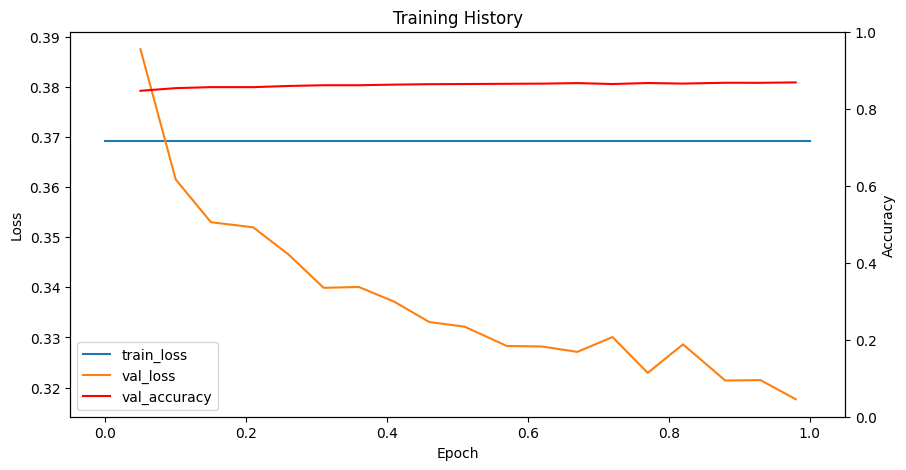

In [14]:
# Get loss, val_loss, and the computed metric from history
loss = [x['loss'] for x in history if 'loss' in x]
val_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

# Get accuracy value 
metric = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]

epochs_loss = [x['epoch'] for x in history if 'loss' in x]
epochs_eval = [x['epoch'] for x in history if 'eval_loss' in x]

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

# Plot loss and val_loss on the first y-axis
# For the loss we plot a horizontal line because we have just one loss value (after the first epoch)
# Exchange the two lines below if you trained multiple epochs
line1 = ax1.plot([0]+epochs_loss, loss*2, label='train_loss')
#line1 = ax1.plot(epochs_loss, loss, label='train_loss')

line2 = ax1.plot(epochs_eval, val_loss, label='val_loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Plot the computed metric on the second y-axis
line3 = ax2.plot(epochs_eval, metric, color='red', label='val_accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_ylim([0, 1])

# Combine the lines from both y-axes and create a single legend
lines = line1 + line2 + line3
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='lower left')

# Show the plot
plt.title("Training History")
plt.show()

# Save and Load the finetuned model

In [15]:
def save_model(model,filepath):
# Saves all parameters that were changed during finetuning

    # Create a dictionary to hold the non-frozen parameters
    non_frozen_params = {}

    # Iterate through all the model parameters
    for param_name, param in model.named_parameters():
        # If the parameter has requires_grad=True, add it to the dictionary
        if param.requires_grad:
            non_frozen_params[param_name] = param

    # Save only the finetuned parameters 
    torch.save(non_frozen_params, filepath)

    
def load_model(filepath, num_labels=1):
# Creates a new PT5 model and loads the finetuned weights from a file

    # load a new model
    model, tokenizer = PT5_classification_model(num_labels=num_labels)
    
    # Load the non-frozen parameters from the saved file
    non_frozen_params = torch.load(filepath)

    # Assign the non-frozen parameters to the corresponding parameters of the model
    for param_name, param in model.named_parameters():
        if param_name in non_frozen_params:
            param.data = non_frozen_params[param_name].data

    return tokenizer, model

This saves only the finetuned weights to a .pth file

It is a 10 MB File, while the entire model would be around 4.8 GB

In [16]:
save_model(model,"./PT5_secstr_finetuned.pth")

To load the weights again, we initialize a new PT5 model from the pretrained checkpoint and load the LoRA weights afterwards

You need to specifiy the correct num_labels here

In [17]:
tokenizer, model_reload = load_model("./PT5_secstr_finetuned.pth", num_labels=3)

loading configuration file config.json from cache at /data2/cache/huggingface/hub/models--Rostlab--prot_t5_xl_uniref50/snapshots/973be27c52ee6474de9c945952a8008aeb2a1a73/config.json
Model config T5Config {
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 16384,
  "d_kv": 128,
  "d_model": 1024,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 24,
  "num_heads": 32,
  "num_layers": 24,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "transformers_version": "4.26.1",
  "use_cache": true,
  "vocab_size": 128
}

loading weights file pytorch_model.bin from cache at /data2/cache/huggingface/hub/models--Rostlab--prot_t5_xl_uniref50/s

All the weights of T5EncoderModel were initialized from the model checkpoint at Rostlab/prot_t5_xl_uniref50.
If your task is similar to the task the model of the checkpoint was trained on, you can already use T5EncoderModel for predictions without further training.
loading file spiece.model from cache at /data2/cache/huggingface/hub/models--Rostlab--prot_t5_xl_uniref50/snapshots/973be27c52ee6474de9c945952a8008aeb2a1a73/spiece.model
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /data2/cache/huggingface/hub/models--Rostlab--prot_t5_xl_uniref50/snapshots/973be27c52ee6474de9c945952a8008aeb2a1a73/special_tokens_map.json
loading file tokenizer_config.json from cache at /data2/cache/huggingface/hub/models--Rostlab--prot_t5_xl_uniref50/snapshots/973be27c52ee6474de9c945952a8008aeb2a1a73/tokenizer_config.json
loading configuration file config.json from cache at /data2/cache/huggingface/hub/models--Rostlab--prot_t5_xl_uniref50/snapshots/973be

ProtT5_Classfier
Trainable Parameter: 1208144899
ProtT5_LoRA_Classfier
Trainable Parameter: 2510851



To check if the original and the reloaded models are identical we can compare weights

In [18]:
# Put both models to the same device
model=model.to("cpu")
model_reload=model_reload.to("cpu")

# Iterate through the parameters of the two models and compare the data
for param1, param2 in zip(model.parameters(), model_reload.parameters()):
    if not torch.equal(param1.data, param2.data):
        print("Models have different weights")
        break
else:
    print("Models have identical weights")

Models have identical weights


# Make predictions on a test set

This time we take the test data we prepared before

In [19]:
# Drop unneeded columns (remember, mask was already included as -100 values to label)
my_test=my_test[["sequence","label"]]

# Preprocess sequences
my_test["sequence"]=my_test["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
my_test['sequence']=my_test.apply(lambda row : " ".join(row["sequence"]), axis = 1)
my_test.head(5)

,sequence,label
0,M T P A V T T Y K L V I N G K T L K G E T T T ...,"[-100, -100, -100, -100, 0, 1, 1, 1, 1, 1, 1, ..."
1,M N D Q E K I D K F T H S Y I N D D F G L T I ...,"[-100, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 1, ..."
2,G P G F M R D S G S K A S S D S Q D A N Q C C ...,"[-100, -100, -100, -100, -100, -100, -100, -10..."
3,S N A L S R N E V L L N G D I N F K E V R C V ...,"[-100, -100, -100, -100, -100, -100, -100, 0, ..."
4,M A K G K S E V V E Q N H T L I L G W S D K L ...,"[-100, -100, -100, -100, -100, -100, -100, -10..."


Then we create predictions on our test data using the model we trained before

In [20]:
# Set the device to use
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Create Dataset
test_set=create_dataset(tokenizer,list(my_test['sequence']),list(my_test['label']))
# Make compatible with torch DataLoader
test_set = test_set.with_format("torch", device=device)

# For token classification we need a data collator here to pad correctly
data_collator = DataCollatorForTokenClassification(tokenizer) 

# Create a dataloader for the test dataset
test_dataloader = DataLoader(test_set, batch_size=16, shuffle = False, collate_fn = data_collator)

# Put the model in evaluation mode
model.eval()

# Make predictions on the test dataset
predictions = []
# We need to collect the batch["labels"] as well, this allows us to filter out all positions with a -100 afterwards
padded_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # Padded labels from the data collator
        padded_labels += batch['labels'].tolist()
        # Add batch results(logits) to predictions, we take the argmax here to get the predicted class
        predictions += model(input_ids, attention_mask=attention_mask).logits.argmax(dim=-1).tolist()

100%|███████████████████████████████████████████| 23/23 [01:34<00:00,  4.13s/it]


Finally, we compute our desired performance metric for the test data

In [21]:
# to make it easier we flatten both the label and prediction lists
def flatten(l):
    return [item for sublist in l for item in sublist]

# flatten and convert to np array for easy slicing in the next step
predictions = np.array(flatten(predictions))
padded_labels = np.array(flatten(padded_labels))

# Filter out all invalid (label = -100) values
predictions = predictions[padded_labels!=-100]
padded_labels = padded_labels[padded_labels!=-100]

# Calculate classification Accuracy
print("Accuracy: ", accuracy_score(padded_labels, predictions))

Accuracy:  0.8460932598219173


Great, 84.6% Accuracy is a decent test performance for the "new_pisces" dataset (see results in [Table 7](https://ieeexplore.ieee.org/ielx7/34/9893033/9477085/supp1-3095381.pdf?arnumber=9477085) "NEW364" )

Further hyperparameter optimization and using a CNN prediction head will further increase performance